<a href="https://colab.research.google.com/github/thedavidemmanuel/transfer_learning_assignment/blob/main/Transfer_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Classification using Transfer Learning

## Setup and Data Preparation

First, we'll install and set up Kaggle to download our dataset. Then we'll unzip the downloaded data.


In [ ]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d techsash/waste-classification-data
!unzip waste-classification-data.zip



## Import Libraries and Set Random Seed

We import necessary libraries and set a random seed for reproducibility.


In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## Data Generators and Augmentation

Here we set up our data generators with augmentation techniques to increase the diversity of our training data and improve model generalization.


In [ ]:
# Define paths to train and test directories
train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'


# Set up data generators with improved data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x/255.0
)

# Initialize data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Classes:", train_generator.class_indices)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Classes: {'O': 0, 'R': 1}


## Model Creation Function

This function creates and compiles our models using transfer learning. We freeze the base model weights and add custom layers on top.

## Create and Summarize Models

We create three models using different pre-trained architectures: VGG16, ResNet50, and DenseNet121.



In [ ]:
# Function to create and compile model
def create_model(base_model, model_name):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Create models
vgg_model = create_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'VGG16')
resnet_model = create_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'ResNet50')
densenet_model = create_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 'DenseNet121')

# Print model summaries
for model in [vgg_model, resnet_model, densenet_model]:
    print(f"\n{model.name} Summary:")
    model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

functional_2 Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 15,765,313 (60.14 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


functional_3 Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


functional_4 Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,612,417 (32.85 MB)

 Trainable params: 1,574,913 (6.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

# Define Callbacks, Training and Evaluation

Here, we define callbacks for early stopping and learning rate reduction. This optimizes the training process.

We then create a function to train and evaluate the model, plotting the training history.

Finally, we train and evaluate the three models (VGG16, ResNet50, DenseNet121).


Training and evaluating VGG16...
Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 314s 440ms/step - accuracy: 0.8566 - loss: 0.6449 - val_accuracy: 0.8675 - val_loss: 0.5486 - learning_rate: 1.0000e-04
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 314s 442ms/step - accuracy: 0.8602 - loss: 0.5136 - val_accuracy: 0.8464 - val_loss: 0.5184 - learning_rate: 1.0000e-04
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 322s 442ms/step - accuracy: 0.8658 - loss: 0.4615 - val_accuracy: 0.8739 - val_loss: 0.4501 - learning_rate: 1.0000e-04
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 332s 456ms/step - accuracy: 0.8634 - loss: 0.4379 - val_accuracy: 0.8544 - val_loss: 0.4689 - learning_rate: 1.0000e-04
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 309s 433ms/step - accuracy: 0.8674 - loss: 0.4207 - val_accuracy: 0.8404 - val_loss: 0.4843 - learning_rate: 1.0000e-04
Epoch 6/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8657 - loss: 0.4110
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
7

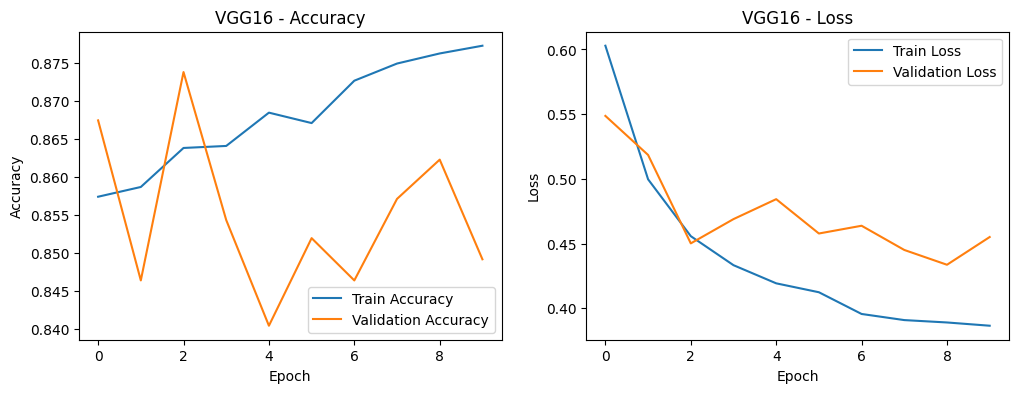


Training and evaluating ResNet50...
Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 320s 430ms/step - accuracy: 0.5718 - loss: 11.2610 - val_accuracy: 0.6717 - val_loss: 2.0066 - learning_rate: 1.0000e-04
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 296s 416ms/step - accuracy: 0.6270 - loss: 1.7225 - val_accuracy: 0.6665 - val_loss: 1.1539 - learning_rate: 1.0000e-04
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 294s 413ms/step - accuracy: 0.6475 - loss: 1.0811 - val_accuracy: 0.5659 - val_loss: 0.9046 - learning_rate: 1.0000e-04
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 302s 424ms/step - accuracy: 0.6568 - loss: 0.8437 - val_accuracy: 0.6789 - val_loss: 0.7496 - learning_rate: 1.0000e-04
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 315s 413ms/step - accuracy: 0.6739 - loss: 0.7362 - val_accuracy: 0.5913 - val_loss: 0.7203 - learning_rate: 1.0000e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.6883 - loss: 2.0016
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step


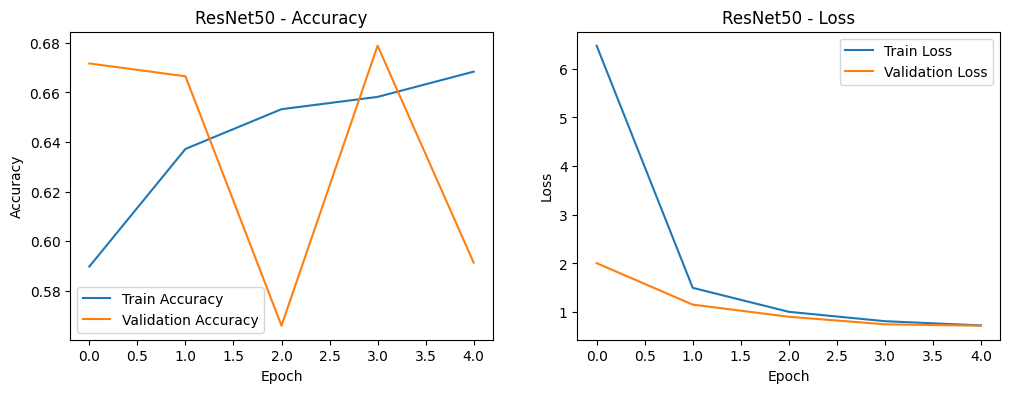


Training and evaluating DenseNet121...
Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 363s 468ms/step - accuracy: 0.8422 - loss: 11.4375 - val_accuracy: 0.8587 - val_loss: 3.2314 - learning_rate: 1.0000e-04
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 308s 432ms/step - accuracy: 0.9133 - loss: 2.4472 - val_accuracy: 0.9025 - val_loss: 1.2139 - learning_rate: 1.0000e-04
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 341s 459ms/step - accuracy: 0.9207 - loss: 0.9834 - val_accuracy: 0.9133 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 383s 462ms/step - accuracy: 0.9265 - loss: 0.5289 - val_accuracy: 0.8667 - val_loss: 0.5160 - learning_rate: 1.0000e-04
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 314s 442ms/step - accuracy: 0.9221 - loss: 0.3793 - val_accuracy: 0.9232 - val_loss: 0.3368 - learning_rate: 1.0000e-04
Epoch 6/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 324s 456ms/step - accuracy: 0.9283 - loss: 0.3096 - val_accuracy: 0.9260 - val_loss: 0.2901 - learning_rate: 1.0000e-04

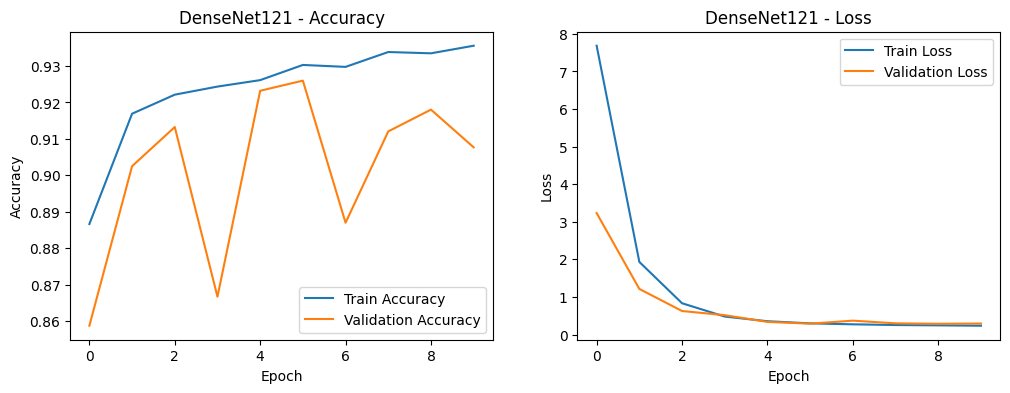

In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)

# Function to train and evaluate model
def train_and_evaluate_model(model, model_name):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator)

    # Calculate additional metrics
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype("int32")
    y_true = test_generator.classes

    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return test_accuracy, test_loss, precision, recall, f1

# Train and evaluate models
models = [
    (vgg_model, "VGG16"),
    (resnet_model, "ResNet50"),
    (densenet_model, "DenseNet121")
]

results = {}

for model, name in models:
    print(f"\nTraining and evaluating {name}...")
    accuracy, loss, precision, recall, f1 = train_and_evaluate_model(model, name)
    results[name] = {
        "Accuracy": accuracy,
        "Loss": loss,
        "Precision": precision,
        "Recall": recall,
        "F1 score": f1
    }

## Results Comparison

Finally, we display a comparison table of our models' performance and visualize the results.


Model Comparison Table:
| Model | Accuracy | Loss | Precision | Recall | F1 score |
|-------|----------|------|-----------|--------|----------|
| VGG16 | 0.8623 | 0.4336 | 0.4635 | 0.3768 | 0.4157 |
| ResNet50 | 0.6717 | 2.0066 | 0.4466 | 0.3498 | 0.3923 |
| DenseNet121 | 0.9180 | 0.2871 | 0.4423 | 0.3795 | 0.4085 |


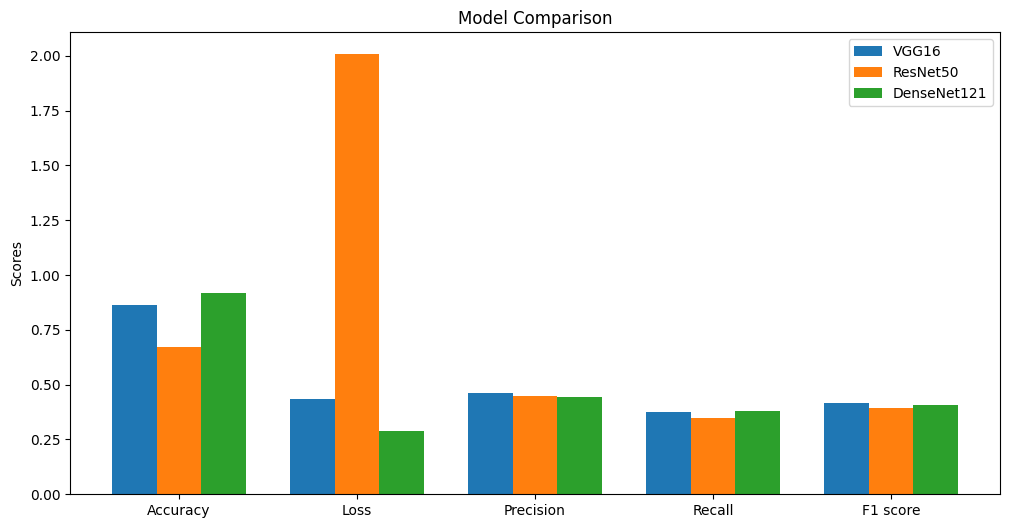

In [13]:
# Display results table
print("Model Comparison Table:")
print("| Model | Accuracy | Loss | Precision | Recall | F1 score |")
print("|-------|----------|------|-----------|--------|----------|")
for model, metrics in results.items():
    print(f"| {model} | {metrics['Accuracy']:.4f} | {metrics['Loss']:.4f} | {metrics['Precision']:.4f} | {metrics['Recall']:.4f} | {metrics['F1 score']:.4f} |")

# Visualize model comparison
metrics = ['Accuracy', 'Loss', 'Precision', 'Recall', 'F1 score']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, (model, model_results) in enumerate(results.items()):
    values = [model_results[metric] for metric in metrics]
    ax.bar(x + i*width, values, width, label=model)

ax.set_ylabel('Scores')
ax.set_title('Model Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()